# Modele prédictif du prix des médicaments

En 5 étapes :

* Import des donnees
* Analyse descriptive
* Preparation des donnees
* Creation d’un modele en cross validation
* Calcul des predictions et soumission

<img src="http://pgxmed.com/wp-content/uploads/2014/03/drugsinhand.jpg" width="40%" height="40%">

# I. Import des données

In [1]:
import pandas as pd
import numpy as np
import unicodedata
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
# for interactive inline plots
#%matplotlib notebook  
# for simple inline plots
%matplotlib inline 
import seaborn as sns
import time, math
#from IPython.display import display

In [2]:
train = pd.read_csv('..\\Projets Tech\\FrenchData\\boites_medicaments_train.csv', encoding='utf-8', sep=';')
test = pd.read_csv('..\\Projets Tech\\FrenchData\\boites_medicaments_test.csv', encoding='utf-8', sep=';')

# convert all strings to lowercase and remove all accents, remove spaces
for i in list(train.select_dtypes(include=['object'])):
    # convert all strings to lowercase and remove all accents
    train[i] = train[i].str.lower().map(lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore'))
    test[i] = test[i].str.lower().map(lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore'))
    # removes space if it is first character
    train[i] = train[i].apply(lambda x : x[1:] if x[0]==' ' else x)    
    test[i] = test[i].apply(lambda x : x[1:] if x[0]==' ' else x)

# convert column name from string to unicode
train.rename(columns=lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore'), inplace=True)
test.rename(columns=lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore'), inplace=True)

# II. Analyse descriptive

Pour une meilleure lisibilité, la partie 'analyse descriptive' est présentée dans un notebook séparé. Voir ce notebook pour plus de détails.

In [3]:
# Prix suit une loi log-normale. Nous prenons donc la distribution du ln des prix
train['logprix'] = train['prix'].apply(np.log)

# III. Préparation des données / Feature engineering

## 1. Converting Dates to numbers

##### Converting years to integer

In [4]:
# TRAINING SET
train['date declar annee'] = train['date declar annee'].astype(int)
train['date amm annee'] = train['date amm annee'].astype(int)

# TEST SET
test['date declar annee'] = test['date declar annee'].astype(int)
test['date amm annee'] = test['date amm annee'].astype(int)

##### Computes the time difference between  'date declar annee' and  date amm annee'

In [5]:
train['date diff'] = train['date declar annee'] - train['date amm annee']
test['date diff'] = test['date declar annee'] - test['date amm annee']

## 2. Nombre de substances et titulaires pour chaque médicament

In [6]:
# COMPUTING THE NUMBER OF SUBSTANCES IN EACH DRUG
train['substances_nb'] = train['substances'].apply(lambda x:  len(x.split(','))    ).astype(int)  
test['substances_nb'] = test['substances'].apply(lambda x:  len(x.split(','))    ).astype(int) 

# COMPUTING THE NUMBER OF TITULAIRES FOR EACH DRUG
train['titulaires_nb'] = train['titulaires'].apply(lambda x:  len(x.split(','))    ).astype(int)  
test['titulaires_nb'] = test['titulaires'].apply(lambda x:  len(x.split(','))    ).astype(int) 

## 3. Traitement des données texte

### 3.1 Identification des features contenant plus d'un label par médicament

Les features texte sont listées dans 'list_temp' :

In [7]:
list_temp = ['substances', 'titulaires' ,'statut', 'etat commerc', 'statut admin', 'type proc', 'forme pharma', 'voies admin']
for i in list_temp:
    print i
    print train[i].apply(lambda x:  len(x.split(','))  ).value_counts()
    print 

substances
1     4940
2     3114
3      236
4      172
5       41
6       16
27       8
30       6
31       4
23       4
8        4
29       4
34       3
10       3
9        2
7        2
11       2
28       1
25       1
17       1
Name: substances, dtype: int64

titulaires
1    8562
2       2
Name: titulaires, dtype: int64

statut
1    8564
Name: statut, dtype: int64

etat commerc
1    8564
Name: etat commerc, dtype: int64

statut admin
1    8564
Name: statut admin, dtype: int64

type proc
1    8564
Name: type proc, dtype: int64

forme pharma
1    8564
Name: forme pharma, dtype: int64

voies admin
1    8163
2     282
3      52
5      30
4      15
6      12
7       8
8       2
Name: voies admin, dtype: int64



Par exemple, 3114 médicaments ont 2 substances, 336 ont 3 substances. On en déduit que:
- les features avec de nombreux labels différents par médicaments (substances, titulaires et voies admin) seront traitées sous la forme de document term matrix
- les features catégorielles (un ou deux label(s) par médicament, sans ordre) pourront etre one-hot-encodées (avec DictVectorizer)
- les features ordinales (un label par médicament, avec ordre) pourront etre simplement encodées (avec LabelEncoder).  

Comme détaillé dans le notebook 'analyse descriptive', nous allons créer les matrices de fréquence des mots (matrices tf-idf), de manière à convertir les champs textes 'features substances, titulaires et voies admin' en nombre binaire, que nous pourrons utiliser avec un algorithme d'apprentissage. Voir http://scikit-learn.org/stable/modules/feature_extraction.html

### 3.2 Tf–idf term weighting for 'substances', 'titulaires', 'voies admin'

In a large text corpus, some words will be very present (e.g. “the”, “a”, “is” in English) hence carrying very little meaningful information about the actual contents of the document.
tf–idf means term-frequency times inverse document-frequency. TfidfVectorizer combines all the options of CountVectorizer and TfidfTransformer in a single model:

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

feat_text = ['titulaires', 'substances', 'voies admin']      

def apply_tfidf_pca(feature, pca_yes=False):                           # PCA: 90% of the variance is retained
    vectorizer = TfidfVectorizer(encoding='utf-8', strip_accents='ascii', lowercase=True)
    tfidf_train = vectorizer.fit_transform(train[feature]).toarray()   # on training set
    tfidf_test = vectorizer.transform(test[feature]).toarray()         # on test set
    if pca_yes==True:
        pca = PCA(n_components=0.90, whiten=True)                      # 0.90 of variance 
        tfidf_train, tfidf_test = pca.fit_transform(tfidf_train), pca.transform(tfidf_test)   # on the training and test set
    return tfidf_train, tfidf_test   

feat_text_tf = []
Xpca_train = np.empty([train.shape[0], 0])
Xpca_test = np.empty([test.shape[0], 0])
for feat in feat_text:
    # computes a tfidf matrix, apply PCA, for each text feature:
    tfidf_pca_train, tfidf_pca_test = apply_tfidf_pca(feat, pca_yes=True)
    print 'Dimension of tf-idf after PCA for', feat, ' - train:',tfidf_pca_train.shape, ' and test:',tfidf_pca_test.shape 
    # builds a matrix containing all the reduced components of each tfidf matrix:
    Xpca_train = np.hstack((Xpca_train, tfidf_pca_train))
    Xpca_test = np.hstack((Xpca_test, tfidf_pca_test))
    # creates a name for each component:    
    feat_text_tf = feat_text_tf + ['component_'+feat[0:5]+'_'+str(x) for x in range(0,tfidf_pca_train.shape[1])]

# creates dataframe out of Xpca_train and Xpca_train  
tfidf_train_df = pd.DataFrame(data=Xpca_train, index=train.index, columns=feat_text_tf)   
tfidf_test_df = pd.DataFrame(data=Xpca_test, index=test.index, columns=feat_text_tf)

# and join to the train and test dataset:
train = train.join(tfidf_train_df)
test = test.join(tfidf_test_df)

print '-' * 80
print 'Total ---', 'train:', tfidf_train_df.shape, 'and test:', tfidf_test_df.shape

Dimension of tf-idf after PCA for titulaires  - train: (8564L, 78L)  and test: (3671L, 78L)
Dimension of tf-idf after PCA for substances  - train: (8564L, 360L)  and test: (3671L, 360L)
Dimension of tf-idf after PCA for voies admin  - train: (8564L, 8L)  and test: (3671L, 8L)
--------------------------------------------------------------------------------
Total --- train: (8564, 446) and test: (3671, 446)


##### Note: Dimension reduction with PCA analysis (on the tf-idf of 'susbtances')

The tf-idf transformation above is followed with a dimension reduction with Princial Component Analysis (PCA), in order to reduce the computing time with the learning algorithm (while retaining 90% of the variance between samples).

Linear dimensionality reduction uses Singular Value Decomposition (SVD) of the data and keeps only the most significant singular vectors to project the data to a lower dimensional space. Here, the normalized term-frequency matrix for 'substances', which is comprised of ~1,300 features, is projected on the ~360 dimensions that explain most (90%) variance between samples.

The whitening operation takes the data in the eigenbasis and divides every dimension by the eigenvalue to normalize the scale. The geometric interpretation of this transformation is that if the input data is a multivariable gaussian, then the whitened data will be a gaussian with zero mean and identity covariance matrix. 

## 4. Synthèse des features du modèle

In [9]:
# features numériques
feat_num = ['libelle_plaquette', 'libelle_ampoule', 'libelle_flacon', 
            'libelle_tube', 'libelle_stylo', 'libelle_seringue',
            'libelle_pilulier', 'libelle_sachet', 'libelle_comprime', 
            'libelle_gelule', 'libelle_film', 'libelle_poche',
            'libelle_capsule'] + ['nb_plaquette', 'nb_ampoule', 
            'nb_flacon', 'nb_tube', 'nb_stylo', 'nb_seringue',
            'nb_pilulier', 'nb_sachet', 'nb_comprime', 'nb_gelule', 
            'nb_film', 'nb_poche', 'nb_capsule', 'nb_ml']
feat_num2 =  ['substances_nb'] + ['titulaires_nb'] 

# features date
feat_dates = ['date declar annee', 'date amm annee'] + ['date diff']

# features ordinales:
feat_ord = ['tx rembours']

# features catégorielles
feat_cat = ['statut', 'etat commerc', 'agrement col',
             'statut admin', 'type proc', 'forme pharma']

# features texte (text converted to low dimension tfidf matrices):
feat_text = ['titulaires', 'substances', 'voies admin'] 

FEATURES = feat_num + feat_num2 + feat_dates + feat_ord 

#### Encodage des features ordinales et catégorielles

- à l'aide de LabelEncoder(), pour le features ordinales: tx rembours
- à l'aide de One-Hot-Encoding, pour le features catégorielles (categorical): agrement col, etat commerc, forme pharma, statut, statut admin, type proc

Note: LabelEncoder assigns an integer to each category (we are assuming we know all of the possible categories up front).  This is called ordinal coding.  It does not add any dimensions to the problem, **but implies an order to the variable that may not actually exist**.

##### Encodage des features ordinales

In [10]:
for c in feat_ord:
    le = LabelEncoder()
    le.fit(train[c].append(test[c]))    # fitting on both train and test
    train[c] = le.transform(train[c])   # transforming on train
    test[c] = le.transform(test[c])     # transforming on test

##### Encodage des features catégorielles par one-hot encoding (using DictVectorizer)

In [11]:
def one_hot_dataframe(data_train, data_test, cols, replace=False):
    vec = DictVectorizer()
    mkdict = lambda row: dict((col, row[col]) for col in cols)
    data_tot = data_train.append(data_test)
    vec.fit(data_tot[cols].apply(mkdict, axis=1))   # fit on both train and test
    # on train
    vecData_train = pd.DataFrame(vec.transform(data_train[cols].apply(mkdict, axis=1)).toarray()).astype(int)
    vecData_train.columns = vec.get_feature_names()
    vecData_train.index = data_train.index
    # on test
    vecData_test = pd.DataFrame(vec.transform(data_test[cols].apply(mkdict, axis=1)).toarray()).astype(int)
    vecData_test.columns = vec.get_feature_names()
    vecData_test.index = data_test.index
    if replace is True:
        data_train = data_train.drop(cols, axis=1)
        data_train = data_train.join(vecData_train)
        data_test = data_test.drop(cols, axis=1)
        data_test = data_test.join(vecData_test)
    return data_train, data_test, list(vecData_train)

''' Alternative: Encodage des features catégorielles par one-hot encoding (using LabelEncoder + OneHotEncoder)
label_encoder = LabelEncoder()
encoder = OneHotEncoder()
data_label_encoded = label_encoder.fit_transform(train_copy['tx rembours'])
train_copy['tx rembours'] = data_label_encoded
data_feature_one_hot_encoded = encoder.fit_transform(train_copy[['tx rembours']])
data_feature_one_hot_encoded_df = pd.DataFrame(data_feature_one_hot_encoded.toarray()).astype(int)'''

train, test, feat_cat_allcol = one_hot_dataframe(train, test, feat_cat, replace=True)

# update the list of features
FEATURES = FEATURES + feat_cat_allcol

##### Enfin, encodage des features textes par la creation d'une matrice tf-idf pour chaque feature texte: voir **section 3.2 ci-dessus**

In [12]:
# update the list of features
FEATURES = FEATURES + feat_text_tf   # pour memoire, feat_text_tf = PCA components of ['titulaires', 'substances', 'voies admin'] 

##### Affiche toutes les features (encodées et pretes pour l'apprentissage)

In [97]:
train[FEATURES].head()

,libelle_plaquette,libelle_ampoule,libelle_flacon,libelle_tube,libelle_stylo,libelle_seringue,libelle_pilulier,libelle_sachet,libelle_comprime,libelle_gelule,libelle_film,libelle_poche,libelle_capsule,nb_plaquette,nb_ampoule,nb_flacon,nb_tube,nb_stylo,nb_seringue,nb_pilulier,nb_sachet,nb_comprime,nb_gelule,nb_film,nb_poche,nb_capsule,nb_ml,substances_nb,titulaires_nb,date declar annee,date amm annee,date diff,tx rembours,agrement col=non,agrement col=oui,etat commerc=arret de commercialisation (le medicament n'a plus d'autorisation),etat commerc=declaration d'arret de commercialisation,etat commerc=declaration de commercialisation,etat commerc=declaration de suspension de commercialisation,forme pharma=capsule,forme pharma=capsule molle,forme pharma=capsule molle gastro-resistant(e),forme pharma=capsule molle ou,forme pharma=collyre,forme pharma=collyre a liberation prolongee,forme pharma=collyre en solution,forme pharma=collyre en suspension,forme pharma=comprime,forme pharma=comprime a croquer,forme pharma=comprime a croquer ou a sucer,forme pharma=comprime a croquer ou dispersible,forme pharma=comprime a liberation modifiee,forme pharma=comprime a liberation prolongee,forme pharma=comprime a sucer,forme pharma=comprime a sucer a croquer ou dispersible,forme pharma=comprime a sucer ou a croquer,forme pharma=comprime a sucer secable,forme pharma=comprime dispersible,forme pharma=comprime dispersible et orodispersible,forme pharma=comprime dispersible orodispersible,forme pharma=comprime dispersible ou a croquer,forme pharma=comprime dispersible secable,forme pharma=comprime drageifie,forme pharma=comprime effervescent(e),forme pharma=comprime effervescent(e) secable,forme pharma=comprime enrobe,forme pharma=comprime enrobe a croquer,forme pharma=comprime enrobe a liberation prolongee,forme pharma=comprime enrobe et comprime enrobe,forme pharma=comprime enrobe et comprime enrobe enrobe,forme pharma=comprime enrobe et comprime enrobe et comprime enrobe,forme pharma=comprime enrobe gastro-resistant(e),forme pharma=comprime enrobe secable,forme pharma=comprime et comprime,forme pharma=comprime et comprime et comprime,forme pharma=comprime et comprime pellicule,forme pharma=comprime gastro-resistant(e),forme pharma=comprime muco-adhesif,forme pharma=comprime orodispersible,forme pharma=comprime orodispersible dispersible,forme pharma=comprime orodispersible secable,forme pharma=comprime osmotique a liberation prolongee,forme pharma=comprime osmotique pellicule a liberation prolongee,forme pharma=comprime ou a sucer a croquer,forme pharma=comprime pellicule,forme pharma=comprime pellicule a liberation modifiee,forme pharma=comprime pellicule a liberation prolongee,forme pharma=comprime pellicule dispersible,forme pharma=comprime pellicule et comprime pellicule,forme pharma=comprime pellicule et comprime pellicule et comprime pellicule,forme pharma=comprime pellicule et comprime pellicule pellicule,forme pharma=comprime pellicule et granules effervescent(e),forme pharma=comprime pellicule gastro-resistant(e),forme pharma=comprime pellicule quadrisecable,forme pharma=comprime pellicule secable,forme pharma=comprime pellicule secable a liberation prolongee,forme pharma=comprime pour suspension buvable,forme pharma=comprime quadrisecable,forme pharma=comprime secable,forme pharma=comprime secable a liberation modifiee,forme pharma=comprime secable a liberation prolongee,forme pharma=comprime secable pellicule,forme pharma=comprime secable pour suspension buvable,forme pharma=creme,forme pharma=creme epaisse pour application,forme pharma=creme pour application,forme pharma=dispositif,forme pharma=dispositif et dispositif,forme pharma=emplatre medicamenteux(se),forme pharma=emulsion et solution et solution pour perfusion,forme pharma=emulsion fluide pour application,forme pharma=emulsion injectable pour perfusion,forme pharma=emulsion pour application,forme pharma=emulsion pour perfusion,forme pharma=film orodispersible,forme pharma=gel,

# IV. Création du modèle prédictif

## 1. Métrique MAPE

La métrique MAPE n'étant pas disponible dans scikit-learn, nous la codons

In [13]:
# Mean Absolute Percentage Error
def mape_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import make_scorer
mape = make_scorer(mape_error, greater_is_better=False)
# used in RandomizedSearchCV (scoring=mape) to optimize hyperparameters w.r.t. MAPE

## 2. Random Forest (benchmark)

Nous allons construire une Foret Aleatoire. Pour eviter le surapprentissage et estimer les performances de notre modèle nous allons utiliser le critère de validation croisée (cross-validation) - méthode k-fold. A 5-fold cross-validation means:
- split the data into 5 parts
- fit on 4-parts
- test accuracy on the remaining part  

This is repeated on all combinations to produce 5 estimates of the accuracy of the model using the current parameter setting. 
Typically the mean and standard deviation of the 5 scores is reported.

### 2.1 Hyperparameters of the estimator

In [47]:
parametersRF = {
              'n_estimators': 50, 
              'n_jobs': -1, 
              'verbose': 1
               }   

### 2.2 Running the model

Here we run the model for the 1st time, without tuning the hyperparameters.

In [49]:
err = []
n_folds = 5
for train_index, test_index in KFold(train.shape[0], n_folds=n_folds):
        
    y = train['logprix'].values
    X = train[FEATURES].values
        
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    clf = RandomForestRegressor(**parametersRF)
    t0 = time.time()
    clf.fit(X_train, y_train)
    print "Fit in %0.3fs" % (time.time() - t0)
    y_pred = clf.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    curr_err = mape_error(np.exp(y_test), np.exp(y_pred))
    err.append(curr_err)
    print curr_err
        
print "*** MAPE Error : mean =", np.mean(err), '; std =', np.std(err)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   31.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Fit in 31.737s
42.9635133952


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   31.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Fit in 31.842s
40.8263688728


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Fit in 33.723s
36.1905394994


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Fit in 34.927s
40.5758092328


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.4s


Fit in 35.356s
39.567119155
*** MAPE Error : mean = 40.024670031 ; std = 2.2132864934


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Cela signifie que notre modèle (non optimisé) prédit les prix des medicaments avec environ 40% d’erreur en moyenne, avec 2% d'écart type.   
Par exemple, si un médicament vaut réellement 10€, notre prédiction pourra etre de 14€ (ou 6€).

##### Showing the 50 most important predictors

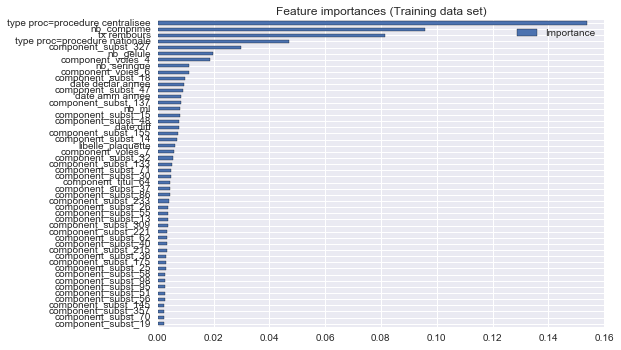

In [50]:
importance_df = pd.DataFrame(clf.feature_importances_, columns=["Importance"], index=list(FEATURES)).sort_values(['Importance'], ascending = True)
importance_df = importance_df.iloc[-50:]   # shows the 50 most important predictors
importance_df.plot(kind='barh', title ="Feature importances (Training data set)", grid=True)

'Type proc=procedure centralisee', nb_comprime and tx_rembours are the 3 features with the most predictive power for predicting the pricetag of drugs.

### 2.3 Optimization

#### Split dataset into training and test set (80/20)

In [51]:
from sklearn.cross_validation import train_test_split
X = train[FEATURES].values
y = train['logprix'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Choose estimator

In [52]:
estimator = RandomForestRegressor(**parametersRF)

#### Choose cross-validation iterator

In [53]:
from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=0)          # 5-fold cross-validation

#### Tune the hyperparameters (using RandomizedSearchCV)

Guidelines for tuning a Random Forest algorithm:

- **Number of trees**: the bigger the better. One way to evaluate and know when to stop is to monitor your error rate while building your forest (or any other evaluation criteria) and detect when it converges. One could do that on the learning set itself or, if available, on an independent test set. Here, we can plot the Out-of-bag error, see diagram below.

- **Tree depth**: there are several ways to control how deep the trees are (limit the maximum depth, limit the number of nodes, limit the number of objects required to split, stop splitting if the split does not sufficiently improves the fit,...). Most of the time, it is recommended to prune (limit the depth of) the trees when dealing with noisy data, in order to avoid overfitting.

- **Number of features** to test at each node: we can perform cross-validation with a wide range of values (including the recommended ones), and then plot a validation curve and be able to identify a maximum pointing out what is the best value for this parameter.


Note on the bias-variance tradeoff: **deeper trees reduces the bias; more trees reduces the variance**.


Applying the cross-validation iterator on the training set with the RandomizedSearchCV method:

In [28]:
from sklearn.grid_search import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

# specify parameters and distributions to sample from
param_dist = {  'n_estimators'   : [200],
                'max_features'   : [None, 'sqrt', 'log2'], 
                'min_samples_leaf':  [1, 3 , 30, 50]  # smaller leaf makes the model more prone to overfitting
              }
    
# run randomized search
n_iter_search = 10                # must be less than the number of combination of param_dist
scoring_method = mape            # optimizes hyperparameters to minimize MAPE     (can try 'mean_squared_error' too)
rf_random_search = RandomizedSearchCV(estimator=estimator, param_distributions=param_dist, scoring=scoring_method,
                                      n_iter=n_iter_search, n_jobs=1, cv=cv, verbose=1)

random_search = rf_random_search.fit(X_train, y_train)
print "Best parameters set found on development set:"
print random_search.best_score_, random_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best parameters set found on development set:
-34.0403719999 {'n_estimators': 200, 'max_features': None, 'min_samples_leaf': 1}


The above randomized search leads to the following optimized hyperparameters:
{'n_estimators': 200, 'max_features': None, 'min_samples_leaf': 1} with a MAPE = 34%.

In [30]:
parametersRF_opt = {
              'n_estimators': random_search.best_params_['n_estimators'], 
              'n_jobs': -1, 
              'verbose': 0, 
              'max_features': random_search.best_params_['max_features'],      
              'min_samples_leaf': random_search.best_params_['min_samples_leaf']   
             }  

#### Plotting the learning curves (diagnosing Bias vs. Variance)

Here we are plotting the training error and the cross-validation error as a function of the training set size (m). This approach will help to determine if our algorithm suffers from high bias or high variance, and then take the actions to improve the algorithm. See http://scikit-learn.org/stable/auto_examples/plot_learning_curve.html   

In [26]:
from sklearn.learning_curve import learning_curve
from sklearn import cross_validation

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score: " + str(scoring))
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring9)
    train_scores_mean = np.mean(train_scores, axis=1) 
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1) 
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    plt.gca().invert_yaxis()
    
    return plt

[learning_curve] Training set sizes: [ 342 1113 1883 2654 3425]
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -   4.8s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -  17.7s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -  30.5s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -  46.6s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set - 1.1min
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -   5.5s
[CV] no parameters to be set .........................................
[CV] ........

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.7min finished


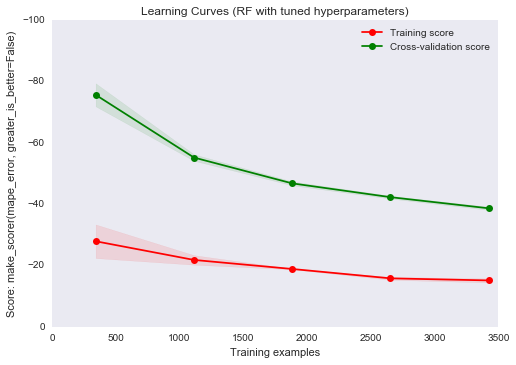

In [27]:
title = 'Learning Curves (RF with tuned hyperparameters)'    
estimator = RandomForestRegressor(**parametersRF_opt)         # regressor with the tuned hyperparameters
plot_learning_curve(estimator, title, X_train, y_train, 
                    ylim=(-100.0, 0.), cv=2, scoring=mape)
plt.show()

##### Determining the optimal number of trees: plotting the OOB error as a function of the number of trees

The RandomForestRegressor is trained using bootstrap aggregation, where each new tree is fit from a bootstrap sample of the training observations z_i = (x_i, y_i). The out-of-bag (OOB) error is the average error for each z_i calculated using predictions from the trees that do not contain z_i in their respective bootstrap sample. This allows the RandomForestRegressor to be fit and validated whilst being trained.  
The OOB error as a function of the number of trees is an estimate of the test set error.

Fitting for n_estimators =  10
Fitting for n_estimators =  60
Fitting for n_estimators =  110
Fitting for n_estimators =  160
Fitting for n_estimators =  210
Fitting for n_estimators =  260
Fitting for n_estimators =  310
Fitting for n_estimators =  360
Fitting for n_estimators =  410
Fitting for n_estimators =  460


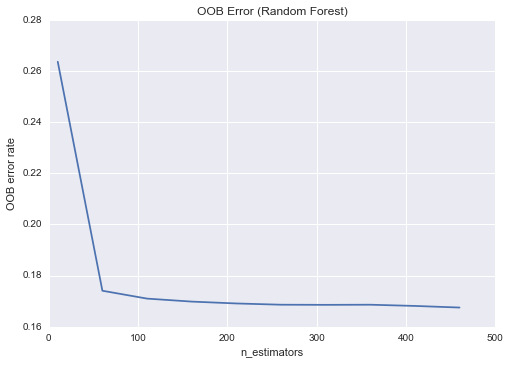

In [34]:
def plot_OOB_curve(X, y, n_estimators):
    
    # see http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
    #Using the warm_start parameter to add trees 1 by 1 (or N by N) and monitor oob_score_ 
    forest = RandomForestRegressor(**parametersRF_opt)
    
    error_rate = []
    for i in range(10, n_estimators, 50):
        print 'Fitting for n_estimators = ', i
        forest.set_params(warm_start=True, oob_score=True, n_estimators=i)
        forest.fit(X, y)
        oob_error = 1 - forest.oob_score_
        error_rate.append((i, oob_error))  

    plt.figure()
    plt.title("OOB Error (Random Forest)")
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.plot( *zip(*error_rate) ) #, 'x' , linewidth=2 )

plot_OOB_curve(X_train, y_train, 500)

It seems that 200 trees would be a good trade-off between accuracy and performance. However, it appears that the OOB keeps decreasing with the number of trees (even with n > 400). We might want to use a higher number of trees (n = 1000?) when training the algorithm for the final submission in order to increase as much as possible the accuracy.

There is a large gap between the training error and CV error, which means the learning algorithm is suffering from high variance (overfitting). Hence, we should try the following:
- Getting more training data
- Trying smaller sets of features
- Trying to increase regularization (case of Neural Network, for example)

##### Determining the optimal tree depth: plotting the error as a function of the tree depth

In [32]:
from sklearn.learning_curve import validation_curve

def plot_validation_curve(estimator, title, X, y, param_name=None, param_range=None, ylim=None, cv=None, scoring=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    '''Source:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
    #example-model-selection-plot-validation-curve-py'''

    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=n_jobs, verbose=2)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    if ylim is not None:
        plt.ylim(*ylim)
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score: " + str(scoring))
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()

[CV] min_samples_leaf=1.0 ............................................
[CV] ................................... min_samples_leaf=1.0 -  56.7s
[CV] min_samples_leaf=6.44444444444 ..................................
[CV] ......................... min_samples_leaf=6.44444444444 -  47.7s
[CV] min_samples_leaf=11.8888888889 ..................................
[CV] ......................... min_samples_leaf=11.8888888889 -  41.9s
[CV] min_samples_leaf=17.3333333333 ..................................
[CV] ......................... min_samples_leaf=17.3333333333 -  37.9s
[CV] min_samples_leaf=22.7777777778 ..................................
[CV] ......................... min_samples_leaf=22.7777777778 -  35.5s
[CV] min_samples_leaf=28.2222222222 ..................................
[CV] ......................... min_samples_leaf=28.2222222222 -  33.9s
[CV] min_samples_leaf=33.6666666667 ..................................
[CV] ......................... min_samples_leaf=33.6666666667 -  32.6s
[CV] m

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 14.0min finished


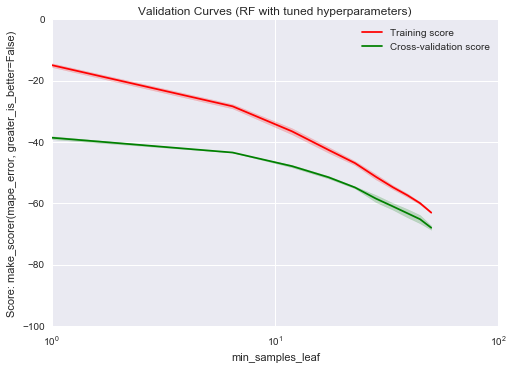

In [33]:
title = 'Validation Curves (RF with tuned hyperparameters)'    
estimator = RandomForestRegressor(**parametersRF_opt)         # regressor with the tuned hyperparameters
plot_validation_curve(estimator, title, X_train, y_train, param_name='min_samples_leaf', param_range = np.linspace(1, 50, 10), 
                    ylim=(-100.0, 0.), cv=2, scoring=mape)

It appears that a fully developped tree, i.e. a tree with maximum depth (min_samples_leaf=1), leads to the best results (minimal error on the training and cross-validation sets).

#### Evaluation on the test set

In [36]:
estimator = RandomForestRegressor(**parametersRF_opt)
estimator.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [37]:
print 'MAPE (test set) =', mape_error(np.exp(y_test), np.exp(estimator.predict(X_test)))

MAPE (test set) = 41.5795705826


# V. Calcul des prédictions et soumission sur Datascience.net

As discussed above (OOB error diagram), we will use a higher number of trees for the final submission:

In [54]:
parametersRF_opt = {
              'n_estimators': 1000, 
              'n_jobs': -1, 
              'verbose': 0, 
              'max_features': None,      
              'min_samples_leaf': 1   
             }  

In [55]:
clf = RandomForestRegressor(**parametersRF_opt)

# On entraine de nouveau le modèle, cette fois sur l'intégralité des données du training set
y = train['logprix'].values
X = train[FEATURES].values
clf.fit(X, y)

# Puis on calcule les predictions sur le TEST dataset:
FEATURES_TEST = FEATURES
X_final_test = test[FEATURES_TEST].values
predictions = np.exp(clf.predict(X_final_test))

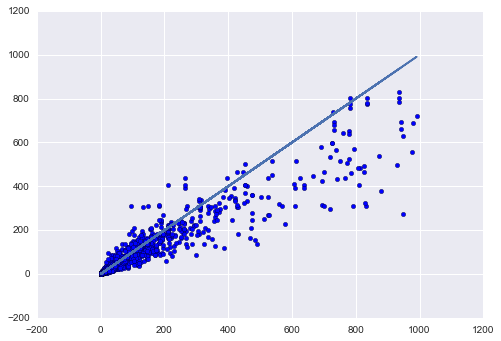

In [56]:
# representation graphique de la prediction du prix par rapport au vrai prix, pour le training set
plt.scatter(train['prix'], np.exp(clf.predict(X)))
plt.plot(train['prix'],train['prix'])
plt.show()

In [57]:
print 'MAPE (test set) =', mape_error(np.exp(y_test), np.exp(clf.predict(X_test)))

MAPE (test set) = 14.5250234772


In [58]:
pd.DataFrame(predictions, index=test['id']).to_csv('soumission.csv', header=['prix'], sep = ';')

Puis finalement uploader le fichier `soumission.csv` sur [Datascience.net](www.datascience.net)

##### Saving the fitted model to a file

In [59]:
import cPickle as pickle 
pickle.dump(clf, open("best_model.pkl", "wb"))
#clf = pickle.load(open("best_model.pkl", "rb"))